In [455]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [456]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\simon\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['bar', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [744]:
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

In [745]:
import torch
from torch import nn
from torch.utils import data as ptdata

In [746]:
import data
from utils import standard_train_step, reset_seed, smooth_plot, l2_regularization, Flatten
from functional import make_functional, functional_mod_fw, fw_linearize

In [747]:
device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
print(device)

cuda


In [748]:
reset_seed(device)

## Import data

In [751]:
train_loader, test_loader = data.load_boston()

In [774]:
train_loader, test_loader = data.load_mnist()

## Define model

In [752]:
def init_nn():
    return nn.Sequential(
        nn.Linear(Xtrain.shape[1], 30),
        nn.ReLU(),
        nn.Linear(30, 1)
    )

In [753]:
loss = nn.MSELoss()

In [775]:
def init_nn():
    return nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5),
        nn.ReLU(),
        nn.Conv2d(10, 20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(20, 20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(180, 10),
        nn.LogSoftmax(dim=1)
    )

In [776]:
loss = nn.NLLLoss()

In [777]:
net = init_nn()

In [778]:
torch.save(net.state_dict(), 'temporary.pt')

## Standard training

In [779]:
net = init_nn().to(device)
net.load_state_dict(torch.load('temporary.pt'))

<All keys matched successfully>

In [780]:
opt = torch.optim.Adam(params=net.parameters(), lr=1e-3)

In [781]:
losses_adam = []
for epoch in range(1):
    for xb, yb in tqdm.tqdm(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        l = standard_train_step(net, loss, opt, xb, yb, C=1e-3)
        losses_adam.append(l)

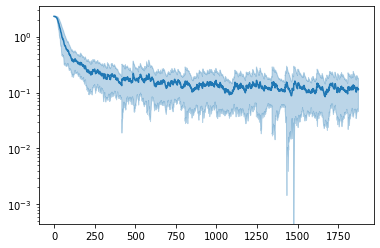

In [782]:
smooth_plot(losses_adam)
plt.yscale('log')

In [829]:
net = init_nn().to(device)
net.load_state_dict(torch.load('temporary.pt'))

<All keys matched successfully>

In [830]:
# Build a copy of the current parameters
v = []
for p in net.parameters():
    v.append(p.data.clone().detach().requires_grad_(True).to(device))
v = tuple(v)

In [831]:
# Build another copy to track the gradients
d = []
for p in net.parameters():
    d.append(torch.zeros_like(p).to(device))

In [832]:
rho = 0.9
step_size = 0.01

In [833]:
def sca_step(xb, yb):
    
        # Linearize around current point
        params, names = make_functional(net)
        
        net_linearized, ypred = fw_linearize(lambda *p: functional_mod_fw(xb, net, names, *p), params, \
                                   create_graph=True, strict=True)
        ypred = ypred[0]
        
        jvp_w0 = net_linearized(params)
        
        def surrogate_loss(v):
            jvp_v = net_linearized(v)
            l = rho * loss(ypred + jvp_v - jvp_w0, yb) + \
                l2_regularization(v, C=1e-3)
            dloss = 0
            for (di, pi, vi) in zip(d, params, v):
                dloss = dloss + torch.sum(di*(pi - vi))
            return l + (1 - rho)*dloss
        
        opt_surrogate = torch.optim.Adam(params=v, lr=1e-3)
        for _ in range(1):
            l = surrogate_loss(v)
            l.backward(retain_graph=True)
            opt_surrogate.step()
            opt_surrogate.zero_grad()
        
        grads = torch.autograd.grad(loss(functional_mod_fw(xb, net, names, *params), yb), params)
        for i in range(len(d)):
            d[i] = (1 - rho)*d[i] + rho*grads[i] 
        
        with torch.no_grad():
            for i in range(len(params)):
                _ = params[i].set_((1 - step_size)*params[i] + step_size*v[i])
        
        return loss(ypred, yb).item()

In [834]:
losses_sca = []
for epoch in range(1):
    for xb, yb in tqdm.tqdm(train_loader):
        
        xb, yb = xb.to(device), yb.to(device)
        losses_sca.append(sca_step(xb, yb))

KeyboardInterrupt: 

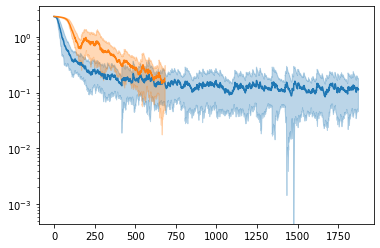

In [835]:
smooth_plot(losses_adam)
smooth_plot(losses_sca)
plt.yscale('log')